## Model Diagnostics

We have now constructed our model.  Lets take a closer look at the results.

In [1]:
# Reading in neccessary packages
from datetime import date, timedelta
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.utils import resample


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv('Data/ford.csv', index_col='Date')

# Calculates the MSE
def mse(x, y):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds)
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return np.mean(np.square(preds-unscaled_yTest)), preds, unscaled_yTest

# This function accepts the raw data and transforms it into the form required for the LSTM NN.  
# - It removes unneccessary columns
# - scales the data between 0 and 1
# - transforms into numpy arrays
def transform(df, n=40):
    df = pd.DataFrame(df['Open'])  # Removing all the other columns as we are only predicting if we should buy based on the opening stock price

    
    # Normalizing to 0-1 range
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), columns=df.columns, index=pd.to_datetime(df.index))


    # Creating 40 columns that give the past 40 day opening stock price
    for i in range(1, n + 1):
        df[f'Open-{i}'] = df['Open'].shift(i)

    # Subsetting for the neccessary columns
    df = df.iloc[40:, 0:]

    # Splitting into training and testing data (test size is about last 2 years)
    dt = pd.to_datetime(date(2020, 11, 17) - timedelta(days=730))
    train = df[df.index < dt]
    test = df[df.index >= dt]     

    # Splitting into appropriat x and y values
    xTrain = train.iloc[:, 1:]
    yTrain = train.iloc[:, 0]
    xTest = test.iloc[:, 1:]
    yTest = test.iloc[:, 0]

    # Converting to numpy arrays to feed into model
    xTrain = xTrain.to_numpy()
    yTrain = yTrain.to_numpy()
    xTest = xTest.to_numpy()
    yTest = yTest.to_numpy()

    # Reshaping to get correct form
    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

    return xTrain, yTrain, xTest, yTest, scaler

def saveModel(model, name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"{location}/{name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{location}/{name}.h5")
    print("Saved model to disk")

def loadModel(name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # load json and create model
    json_file = open(f"{location}/{name}.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(f"{location}/{name}.h5")
    return model
    print("Loaded model from disk")

LAG = 40

xTrain, yTrain, xTest, yTest, scaler = transform(data, LAG)

0.026805853110043028
0.004708414955350479


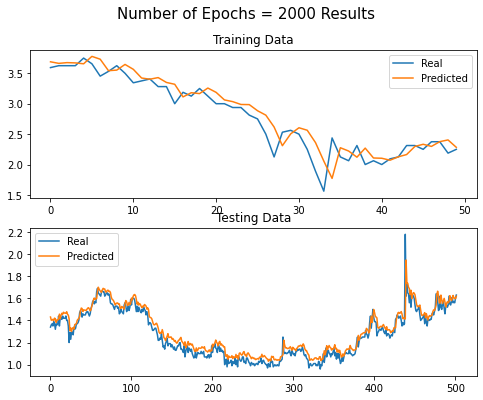

In [3]:
model = loadModel(name='fordEpochTraining2000')

# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Number of Epochs = 2000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y[0:50])
axes[0].plot(yHat[0:50])
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

## Model Diagnostics and Performance

Looking at the plot of our model, we can see it does very well on the training data, but systematically overestimates the the testing data.  Before deciding if this is in fact a problem, lets see the results of this in a simulation of stock trades we would like to make.  How these trades are defined is simple, let change = PredictedOpeningPrice - CurrentOpeningPrice.  That is change represents the predicted change in the opening stock price between the current day and the next day.  If change is positive (> 0), we will buy stock at the current opening price since we believe we wil be able to sell it tomorrow for a profit.  If change is negative (<=0), we will sell stock (if we have any to sell) at the current opening price since we think the price is going to go down.  Lets see how our model performs using this methodology.  

In [4]:
def formulateData(originalData, residuals, predicted):
    originalData = pd.DataFrame(originalData['Open'])

    originalData['residuals'] = residuals
    originalData['predicted'] = predicted

    originalData['tomorrow'] = originalData['predicted'].shift(-1)

    originalData['action'] = np.where(originalData['tomorrow'] - originalData['Open'] > 0, 'buy', 'sell')

    return originalData

def prediction(scaler, model, x, y):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds)
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return (preds-unscaled_yTest), preds, unscaled_yTest

data = pd.DataFrame(data, index=pd.to_datetime(data.index))
dt = pd.to_datetime(date(2020, 11, 17) - timedelta(days=730))
fordTrain = data[data.index < dt].iloc[40:,:]
fordTest = data[data.index >= dt]
residuals, yHat, y = prediction(scaler, model, xTest, yTest)
tradingActions = formulateData(fordTest, residuals, yHat)

tradingActions

,Open,residuals,predicted,tomorrow,action
Date,,,,,
2018-11-19,1.34,0.091030,1.431030,1.402103,buy
2018-11-20,1.36,0.042103,1.402103,1.404446,buy
2018-11-21,1.37,0.034446,1.404446,1.410371,buy
2018-11-23,1.35,0.060371,1.410371,1.398772,buy
2018-11-26,1.39,0.008772,1.398772,1.420981,buy
...,...,...,...,...,...
2020-11-10,1.56,0.066635,1.626635,1.603079,buy
2020-11-11,1.57,0.033079,1.603079,1.601632,buy
2020-11-12,1.56,0.041632,1.601632,1.596276,buy


Now you may notice right away that there appears to be many "buy"'s and only a few "sell"'s.  This trend can be verified with the plot below

Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Test Data)')

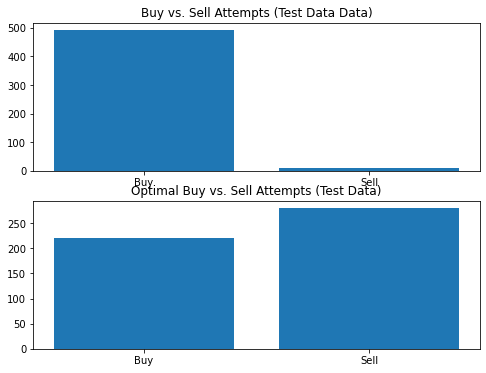

In [5]:
# CITATION: https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm
tradingActions['trueTomorrow'] = tradingActions['Open'].shift(-1)
tradingActions['trueAction'] = np.where(tradingActions['trueTomorrow'] - tradingActions['Open'] > 0, 'buy', 'sell')


fig, axes = plt.subplots(2, figsize=(8, 6))
actions = ['Buy', 'Sell']
students = [np.sum(tradingActions['action'] == 'buy'),np.sum(tradingActions['action'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts (Test Data Data)')

students = [np.sum(tradingActions['trueAction'] == 'buy'),np.sum(tradingActions['trueAction'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Test Data)')

It is clear that we are almost always buying.  This is in stark contrast with the truth where we should actually be selling more than we are buying.  The reason for this is that we are constantly overestimating the truth, this causes our predicted opening price to almost always be larger than our current opening price.  Thus we almost always predict the stock will increase so we buy stock.  Lets check the training data to see how we are doing there as well.

Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Training Data)')

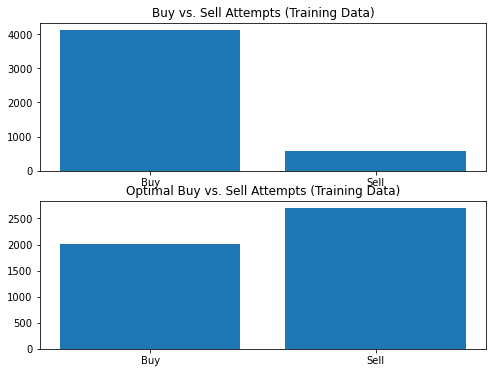

In [6]:
residuals, yHat, y = prediction(scaler, model, xTrain, yTrain)
tradingActions = formulateData(fordTrain, residuals, yHat)

# CITATION: https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm
tradingActions['trueTomorrow'] = tradingActions['Open'].shift(-1)
tradingActions['trueAction'] = np.where(tradingActions['trueTomorrow'] - tradingActions['Open'] > 0, 'buy', 'sell')

fig, axes = plt.subplots(2, figsize=(8, 6))
actions = ['Buy', 'Sell']
students = [np.sum(tradingActions['action'] == 'buy'),np.sum(tradingActions['action'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts (Training Data)')

students = [np.sum(tradingActions['trueAction'] == 'buy'),np.sum(tradingActions['trueAction'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Training Data)')

The results appear to be the same.

We can clearly see that we are attempting to buy stock far more than we are trying to sell.  Of course this begs the question why is this occuring.  The answer is actually quite simple.  Due to the complete overestimation are model makes, we the change in opening stock price (PredictedOpeningPrice - CurrentOpeningPrice) is rarely negative since we always predict the opening stock price to be larger than it actually is.  Clearly, this is a problem.  We now have 3 avenues to choose from to remedy this.  One, we can choose a different model.  Two, simply subtract the average residual from our predicted values to reduce the overestimation.  Third, we can make a crucial observation of our model that will be explained shortly.  First, we immediately disregard option one due to its difficulty and low probability of success. As for options two and three, we will investigate.

### Model Corrections

#### Option 1: Subtract Average Residual

Lets first investigate option two.  To do so lets first divide the training data into subsets.  While this certainly is not ideal to further restrict our validation data, we would like to keep some subset of data as a true validation set.  We will first investigate the residuals to see if they appear to be constant.

In [7]:
residuals, yHat, y = prediction(scaler, model, xTest, yTest)
tradingActionsTest = formulateData(fordTest, residuals, yHat)

tradingActionsTest['tomorrowTruth'] = tradingActionsTest['Open'].shift(-1)
tradingActionsTest['actionTruth'] = np.where(tradingActionsTest['tomorrowTruth']-tradingActionsTest['Open'] >0,
                                            'buy',
                                            'sell')
numDataPoints = int(len(xTest)/2)
tradingActionsTest1 = tradingActionsTest.iloc[0:numDataPoints,:]
tradingActionsTest2 = tradingActionsTest.iloc[numDataPoints:,:]

Text(0.5, 1.0, 'Residuals of Model Predictions')

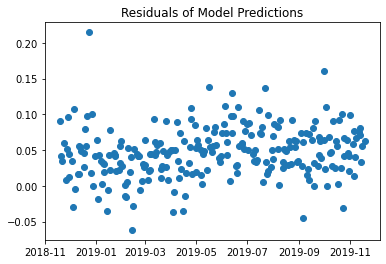

In [8]:
plt.plot(tradingActionsTest1['residuals'],'o')
plt.title('Residuals of Model Predictions')

Looking at the residuals, they do appear to be relatively constant.  It may be feasible to simply drop the model predictions by subtracting the by the average of the residuals.  Lets try this.

In [9]:
avgResidual = np.average(tradingActionsTest1['residuals'])
tradingActionsTest1['residualPrediction'] = tradingActionsTest1['predicted'].values - avgResidual

<ipython-input-9-e56ad59d475a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingActionsTest1['residualPrediction'] = tradingActionsTest1['predicted'].values - avgResidual


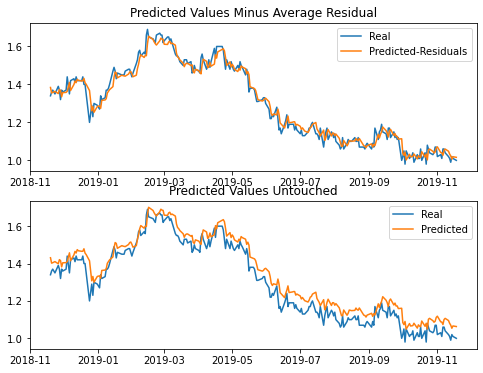

In [10]:
fig, axes = plt.subplots(2, figsize=(8, 6))


# Top Left Subplot
axes[0].plot(tradingActionsTest1['Open'])
axes[0].plot(tradingActionsTest1['residualPrediction'])
axes[0].set_title("Predicted Values Minus Average Residual")
axes[0].legend(['Real', 'Predicted-Residuals'])


# Top Right Subplot
axes[1].plot(tradingActionsTest1['Open'])
axes[1].plot(tradingActionsTest1['predicted'])
axes[1].set_title("Predicted Values Untouched")
axes[1].legend(['Real', 'Predicted'])



In [11]:
tradingActionsTest1['residualAction'] = np.where(tradingActionsTest1['residualPrediction'] - tradingActionsTest1['Open'] > 0, 
                                                 'buy', 
                                                 'sell')


<ipython-input-11-46a8b9a1f9db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingActionsTest1['residualAction'] = np.where(tradingActionsTest1['residualPrediction'] - tradingActionsTest1['Open'] > 0,


Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Training Data)')

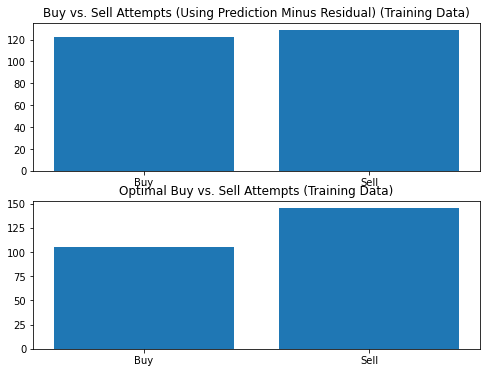

In [12]:
fig, axes = plt.subplots(2, figsize=(8, 6))
actions = ['Buy', 'Sell']
students = [np.sum(tradingActionsTest1['residualAction'] == 'buy'),np.sum(tradingActionsTest1['residualAction'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts (Using Prediction Minus Residual) (Training Data)')

students = [np.sum(tradingActionsTest1['actionTruth'] == 'buy'),np.sum(tradingActionsTest1['actionTruth'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Training Data)')

We have clearly significantly improved the number of times we are selling stocks.  Lets check our test data

In [13]:
tradingActionsTest2['residualPrediction'] = tradingActionsTest2['predicted'].values - avgResidual

<ipython-input-13-0427b667ae11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingActionsTest2['residualPrediction'] = tradingActionsTest2['predicted'].values - avgResidual


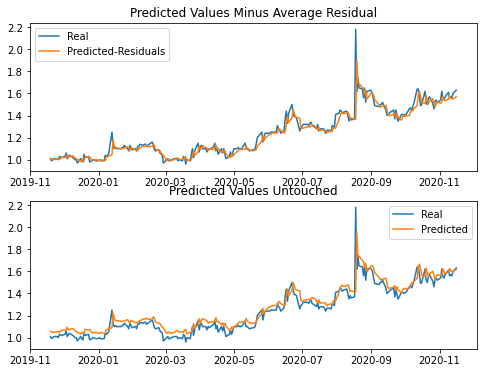

In [14]:
fig, axes = plt.subplots(2, figsize=(8, 6))

tradingActionsTest2


# Top Left Subplot
axes[0].plot(tradingActionsTest2['Open'])
axes[0].plot(tradingActionsTest2['residualPrediction'])
axes[0].set_title("Predicted Values Minus Average Residual")
axes[0].legend(['Real', 'Predicted-Residuals'])


# Top Right Subplot
axes[1].plot(tradingActionsTest2['Open'])
axes[1].plot(tradingActionsTest2['predicted'])
axes[1].set_title("Predicted Values Untouched")
axes[1].legend(['Real', 'Predicted'])

<ipython-input-15-ad17e5ac9d4c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingActionsTest2['residualAction'] = np.where(tradingActionsTest2['residualPrediction'] - tradingActionsTest2['Open'] > 0,


Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Training Data)')

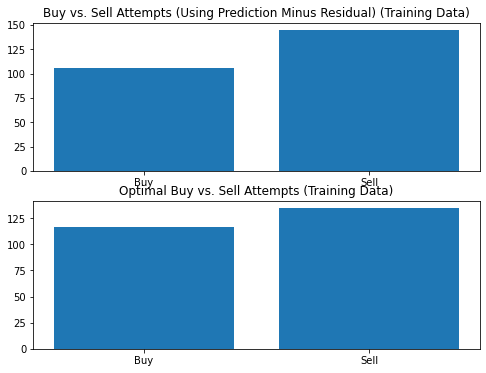

In [15]:
tradingActionsTest2['residualAction'] = np.where(tradingActionsTest2['residualPrediction'] - tradingActionsTest2['Open'] > 0, 
                                                 'buy', 
                                                 'sell')

fig, axes = plt.subplots(2, figsize=(8, 6))
actions = ['Buy', 'Sell']
students = [np.sum(tradingActionsTest2['residualAction'] == 'buy'),np.sum(tradingActionsTest2['residualAction'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts (Using Prediction Minus Residual) (Training Data)')

students = [np.sum(tradingActionsTest2['actionTruth'] == 'buy'),np.sum(tradingActionsTest2['actionTruth'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Training Data)')

Our results are the same. However what must be checked now is how often are we selling or buying when we should be.  (with respect to the truth)

In [17]:
np.sum(tradingActionsTest1['actionTruth'] == tradingActionsTest1['residualAction'])/len(tradingActionsTest1)

0.6135458167330677

With respect to our training data, we are buying/selling correctly about 61% of the time.

In [18]:
np.sum(tradingActionsTest2['actionTruth'] == tradingActionsTest2['residualAction'])/len(tradingActionsTest1)

0.5856573705179283

With respect to our Testing data, we are buying/selling correctly about 59% of the time.  Considering these are stock data, this is actually not bad.  Of course the question must be asked, could this be improved.  One possibility is to instead of taking simply the average of the residual, is to use a moving average.  Lets see how this effects our predictions.

In [19]:
tradingActionsTest1 = tradingActionsTest1[['Open','residuals', 'predicted','tomorrow','tomorrowTruth','actionTruth']]
tradingActionsTest2 = tradingActionsTest2[['Open','residuals', 'predicted','tomorrow','tomorrowTruth','actionTruth']]

In [20]:
for lookBack in range(20,320,20):
    tradingActionsTest = pd.concat([tradingActions.iloc[-lookBack:, :].rename(columns={"trueTomorrow":"tomorrowTruth", "trueAction":"actionTruth"}),
              tradingActionsTest1])
    movingResiduals =[]
    for i in range(lookBack,len(tradingActionsTest)):    
        movingResiduals.append(np.average(tradingActionsTest.iloc[i-lookBack:i,:]['residuals']))

    tradingActionsTest1['movingResiduals'] = movingResiduals
    tradingActionsTest1['residualTomorrow'] = tradingActionsTest1['tomorrow'] - tradingActionsTest1['movingResiduals']
    tradingActionsTest1['residualAction'] = np.where(tradingActionsTest1['residualTomorrow']-tradingActionsTest1['Open']>0,
                                                    'buy',
                                                    'sell')
    print("Look Back: ", lookBack)
    print(np.sum(tradingActionsTest1['actionTruth'] == tradingActionsTest1['residualAction'])/len(tradingActionsTest1))
    print("******************************************")


Look Back:  20
0.6135458167330677
******************************************
Look Back:  40
0.6055776892430279
******************************************
Look Back:  60
0.5697211155378487
******************************************
Look Back:  80
0.5976095617529881
******************************************
Look Back:  100
0.5976095617529881
******************************************
Look Back:  120
0.6215139442231076
******************************************
Look Back:  140
0.6095617529880478
******************************************
Look Back:  160
0.6294820717131474
******************************************
Look Back:  180
0.6374501992031872
******************************************
Look Back:  200
0.6294820717131474
******************************************
Look Back:  220
0.6175298804780877
******************************************
Look Back:  240
0.6095617529880478
******************************************
Look Back:  260
0.601593625498008
**********************************

Using a moving residual average may increase our predictions, however it is very possible that it is simply chance that this occurs.  We can verify this on our test data.  Lets assume we achieve the optimum using a look back of 180.

In [41]:
tradingActionsTest = pd.concat([tradingActionsTest1.iloc[-180:, :].rename(columns={"trueTomorrow":"tomorrowTruth", "trueAction":"actionTruth"}),
              tradingActionsTest2])

tradingActionsTest

movingResiduals =[]
for i in range(180,len(tradingActionsTest)):    
    movingResiduals.append(np.average(tradingActionsTest.iloc[i-180:i,:]['residuals']))
    
  
    


tradingActionsTest2['movingResiduals'] = movingResiduals
tradingActionsTest2['residualTomorrow'] = tradingActionsTest2['tomorrow'] - tradingActionsTest2['movingResiduals']
tradingActionsTest2['residualAction'] = np.where(tradingActionsTest2['residualTomorrow']-tradingActionsTest2['Open']>0,
                                                'buy',
                                                    'sell')

print(np.sum(tradingActionsTest2['actionTruth'] == tradingActionsTest2['residualAction'])/len(tradingActionsTest2))



0.6215139442231076


It appears we have managed to increase our accuracy by about 3-4 percent on the test data.

In [ ]:
fig, axes = plt.subplots(2, figsize=(8, 6))
actions = ['Buy', 'Sell']
students = [np.sum(tradingActions['action'] == 'buy'),np.sum(tradingActions['action'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts (Training Data)')

students = [np.sum(tradingActions['trueAction'] == 'buy'),np.sum(tradingActions['trueAction'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Training Data)')

In [108]:
tradingActionsTest2['residualPrediction'] = tradingActionsTest2['predicted'].values - avgResidual

<ipython-input-108-0427b667ae11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingActionsTest2['residualPrediction'] = tradingActionsTest2['predicted'].values - avgResidual


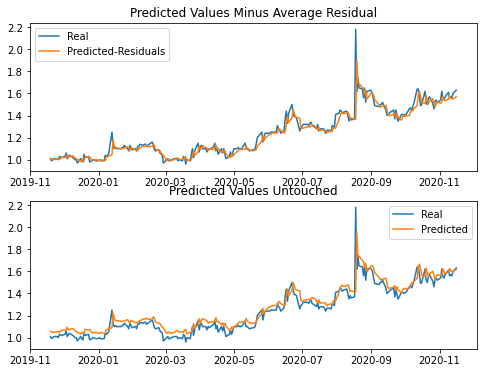

In [109]:
fig, axes = plt.subplots(2, figsize=(8, 6))


# Top Left Subplot
axes[0].plot(tradingActionsTest2['Open'])
axes[0].plot(tradingActionsTest2['residualPrediction'])
axes[0].set_title("Predicted Values Minus Average Residual")
axes[0].legend(['Real', 'Predicted-Residuals'])


# Top Right Subplot
axes[1].plot(tradingActionsTest2['Open'])
axes[1].plot(tradingActionsTest2['predicted'])
axes[1].set_title("Predicted Values Untouched")
axes[1].legend(['Real', 'Predicted'])


It appears to do pretty well!

We can clearly see that we appear to be much closer to the truth.  We must then check to see if this holds for the rest of our testing data.

Text(0.5, 1.0, 'Residuals of Model Predictions')

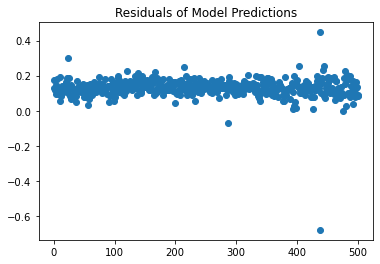

In [107]:
numDataPoints = int(len(xTest))
xValid1 = xTest[0:numDataPoints, 0:39,0:1]
yValid1 = yTest[0:numDataPoints]
xValid2 = xTest[numDataPoints:, 0:39,0:1]
yValid2 = yTest[numDataPoints:]
fordTestValid1 = fordTest.iloc[0:numDataPoints,:]
fordTestValid2 = fordTest.iloc[numDataPoints:,:]

residuals, yHat, y = prediction(scaler, model, xValid1, yValid1)

plt.plot(residuals,'o')
plt.title('Residuals of Model Predictions')

Looking at the residuals, they do appear to be relatively constant.  It may be feasible to simply drop the model predictions by subtracting the by the average of the residuals.  Lets try this.

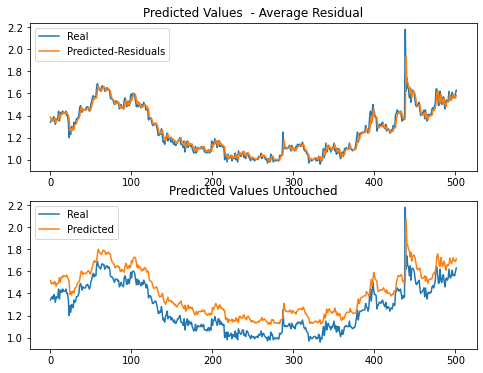

In [52]:
avgResidual = np.average(residuals)
def prediction(scaler, model, x, y, avgResidual):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds) - avgResidual
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return (preds-unscaled_yTest), preds, unscaled_yTest

residuals, yHat, y = prediction(scaler, model, xValid1, yValid1, avgResidual)

fig, axes = plt.subplots(2, figsize=(8, 6))



residuals, yHat, y = prediction(scaler, model, xValid1, yValid1, 0)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Predicted Values Untouched")
axes[1].legend(['Real', 'Predicted'])


residuals, yHat, y = prediction(scaler, model, xValid1, yValid1, avgResidual)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Predicted Values  - Average Residual")
axes[0].legend(['Real', 'Predicted-Residuals'])


Looking above at our results, we can clearly see that this reduces our overestimation of our data.  To further examine this lets ensure that this evens out the amount of times we wish to buy and sells tock

Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Training Data)')

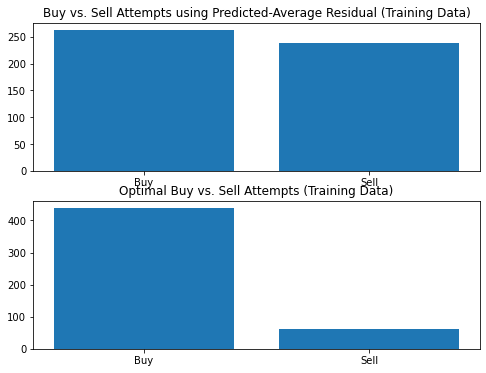

In [53]:
def formulateData(originalData, residuals, predicted):
    print
    originalData = pd.DataFrame(originalData['Open'])

    originalData['residuals'] = residuals
    originalData['predicted'] = predicted

    originalData['tomorrow'] = originalData['predicted'].shift(-1)

    originalData['action'] = np.where(originalData['tomorrow'] - originalData['Open'] > 0, 'buy', 'sell')

    return originalData

fig, axes = plt.subplots(2, figsize=(8, 6))

tradingActions2 = formulateData(fordTestValid1, residuals, yHat)
actions = ['Buy', 'Sell']
students = [np.sum(tradingActions2['action'] == 'buy'),np.sum(tradingActions2['action'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts using Predicted-Average Residual (Training Data)')

fordTestValid1 = pd.DataFrame(fordTestValid1['Open'])
fordTestValid1['TrueTomorrow'] = fordTestValid1['Open'].shift(-1)
fordTestValid1['action'] = np.where(fordTestValid1['TrueTomorrow']-fordTestValid1['Open'], 'buy','sell')
actions = ['Buy', 'Sell']
students = [np.sum(fordTestValid1['action'] == 'buy'),np.sum(fordTestValid1['action'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Training Data)')


This certainly has a clear effect and does a strong job of increasing the number of times we would like to sell stock.  However, it appears to do too good of a job.  This can be see by looking at the second plot that shows the optimum number of buy and sell actions we would like to make.

Of course lets see if this continues for our training data, we we apply this using the exact same residual.

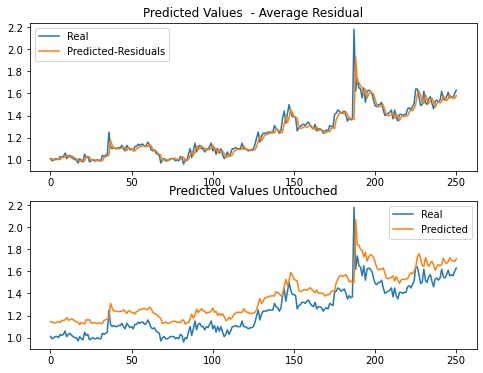

In [9]:
def prediction(scaler, model, x, y, avgResidual):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds) - avgResidual
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return (preds-unscaled_yTest), preds, unscaled_yTest

residuals, yHat, y = prediction(scaler, model, xValid1, yValid1, avgResidual)

fig, axes = plt.subplots(2, figsize=(8, 6))

residuals, yHat, y = prediction(scaler, model, xValid2, yValid2, 0)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Predicted Values Untouched")
axes[1].legend(['Real', 'Predicted'])


residuals, yHat, y = prediction(scaler, model, xValid2, yValid2, avgResidual)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Predicted Values  - Average Residual")
axes[0].legend(['Real', 'Predicted-Residuals'])


Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Testing Data)')

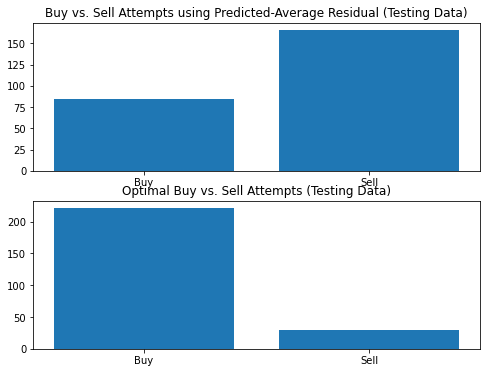

In [11]:
def formulateData(originalData, residuals, predicted):
    print
    originalData = pd.DataFrame(originalData['Open'])

    originalData['residuals'] = residuals
    originalData['predicted'] = predicted

    originalData['tomorrow'] = originalData['predicted'].shift(-1)

    originalData['action'] = np.where(originalData['tomorrow'] - originalData['Open'] > 0, 'buy', 'sell')

    return originalData

fig, axes = plt.subplots(2, figsize=(8, 6))

tradingActions2 = formulateData(fordTestValid2, residuals, yHat)
actions = ['Buy', 'Sell']
students = [np.sum(tradingActions2['action'] == 'buy'),np.sum(tradingActions2['action'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts using Predicted-Average Residual (Testing Data)')

fordTestValid2 = pd.DataFrame(fordTestValid2['Open'])
fordTestValid2['TrueTomorrow'] = fordTestValid2['Open'].shift(-1)
fordTestValid2['action'] = np.where(fordTestValid2['TrueTomorrow']-fordTestValid2['Open'], 'buy','sell')
actions = ['Buy', 'Sell']
students = [np.sum(fordTestValid2['action'] == 'buy'),np.sum(fordTestValid2['action'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Testing Data)')

Again we can see that the results are very similar to the training data.  We end up selling far to much compared to the optimum.  This suffice to say we will disregard this option.

#### Option 3: Disregarding the Truth

Now, as I stated far back, I would explain the crucial observation that would allow us to make an adjustment to handle our models overestimation.  If we look at our models predictions (re-plotted below) it appears to predict the oscillation in the stock extremely well.  That it appears to do a very good job of predicting the oscillations relative to its own predictions.  Thus, to decide when we should buy or sell stock we will instead use the following formula: Let change = NextDayPredictedOpeningPrice - CurrentPredictedOpeningPrice.  If change is greater than 0 then we will try to buy stock otherwise we will try to sell stock.

0.026805853110043028
0.004708414955350479


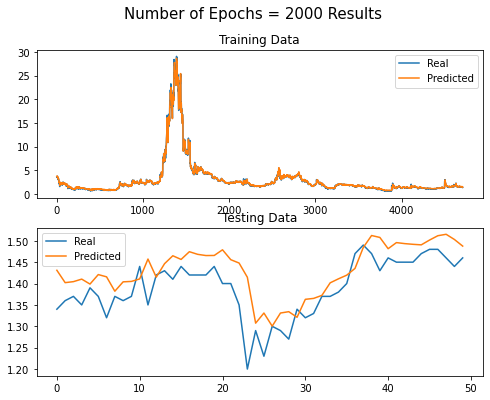

In [82]:
model = loadModel(name='fordEpochTraining2000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Number of Epochs = 2000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y[0:50])
axes[1].plot(yHat[0:50])
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

##### Training Data

In [66]:
def transform2(df, n=40):
    df = pd.DataFrame(df['Open'])  # Removing all the other columns as we are only predicting if we should buy based on the opening stock price

    df = pd.DataFrame(df, columns=df.columns, index=pd.to_datetime(df.index))


    # Creating 40 columns that give the past 40 day opening stock price
    for i in range(1, n + 1):
        df[f'Open-{i}'] = df['Open'].shift(i)

    # Subsetting for the neccessary columns
    df = df.iloc[40:, 0:]

    # Splitting into training and testing data (test size is about last 2 years)
    dt = pd.to_datetime(date(2020, 11, 17) - timedelta(days=730))
    train = df[df.index < dt]
    test = df[df.index >= dt]
    return pd.DataFrame(train['Open']), pd.DataFrame(test['Open'])

fordTrain, fordTest = transform2(data)

In [79]:
meanSquared, yHat, y = mse(xTrain,yTrain)
fordTrain['predictedToday'] = yHat
fordTrain['predictedTomorrow'] = fordTrain['predictedToday'].shift(-4)
fordTrain['action'] = np.where(fordTrain['predictedTomorrow'] - fordTrain['predictedToday'] > 0, 'buy','sell')
fordTrain['truthTomorrow'] = fordTrain['Open'].shift(-1)
fordTrain['trueAction'] = np.where(fordTrain['truthTomorrow'] - fordTrain['Open'] > 0, 'buy','sell')

Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Training Data)')

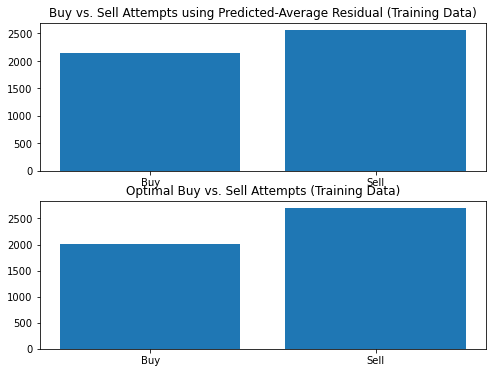

In [80]:
fig, axes = plt.subplots(2, figsize=(8, 6))

actions = ['Buy', 'Sell']
students = [np.sum(fordTrain['action'] == 'buy'),np.sum(fordTrain['action'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts using Predicted-Average Residual (Training Data)')

students = [np.sum(fordTrain['trueAction'] == 'buy'),np.sum(fordTrain['trueAction'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Training Data)')

In [81]:
np.sum(fordTrain['action'] == fordTrain['trueAction'])/len(fordTrain)

0.616005094459775

##### Testing Data

In [72]:
meanSquared, yHat, y = mse(xTest,yTest)
fordTest['predictedToday'] = yHat
fordTest['predictedTomorrow'] = fordTest['predictedToday'].shift(-1)
fordTest['action'] = np.where(fordTest['predictedTomorrow'] - fordTest['predictedToday'] > 0, 'buy','sell')
fordTest['truthTomorrow'] = fordTest['Open'].shift(-1)
fordTest['trueAction'] = np.where(fordTest['truthTomorrow'] - fordTest['Open'] > 0, 'buy','sell')

Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Testing Data)')

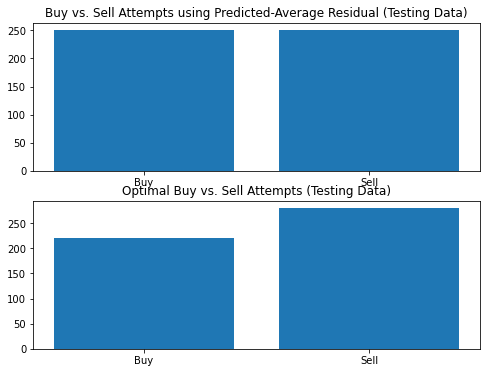

In [73]:
fig, axes = plt.subplots(2, figsize=(8, 6))

actions = ['Buy', 'Sell']
students = [np.sum(fordTest['action'] == 'buy'),np.sum(fordTest['action'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts using Predicted-Average Residual (Testing Data)')

students = [np.sum(fordTest['trueAction'] == 'buy'),np.sum(fordTest['trueAction'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Testing Data)')

In [74]:
np.sum(fordTest['action'] == fordTest['trueAction'])/len(fordTest)

0.3904382470119522

In [75]:
fordTest

,Open,predictedToday,predictedTomorrow,action,truthTomorrow,trueAction
Date,,,,,,
2018-11-19,1.34,1.431030,1.402103,sell,1.36,buy
2018-11-20,1.36,1.402103,1.404446,buy,1.37,buy
2018-11-21,1.37,1.404446,1.410371,buy,1.35,sell
2018-11-23,1.35,1.410371,1.398772,sell,1.39,buy
2018-11-26,1.39,1.398772,1.420981,buy,1.37,sell
...,...,...,...,...,...,...
2020-11-10,1.56,1.626635,1.603079,sell,1.57,buy
2020-11-11,1.57,1.603079,1.601632,sell,1.56,sell
2020-11-12,1.56,1.601632,1.596276,sell,1.60,buy
